# Remake Figure 5

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook is designed to reproduce figures from the paper using the archived data folder. Each section should be possible to run independently.

Note that this notebook is primarily intended for users who wish to replot the existing data in different ways; it does not include code for the analysis itself.

In [1]:
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats
import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
specific_load_dir = str(pathlib.Path(load_dir,'optimization_trials_dualannealing_3D_4D'))

In [6]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [7]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Define Simulation Function

In [8]:
def run_eqtk(N, C0, params, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix, initial concentrations, and parameters.

    See eqtk.solve documentation for more details on the syntax.
    (https://eqtk.github.io/user_guide/generated/highlevel/eqtk.solve.html)

    Parameters
    ----------
    N : Array-like, shape (num_rxns, num_species)
        Input stoichiometry matrix
    C0 : Array-like, shape (num_simulation_points, num_species)
        Initial concentrations of all species for each simulation point.
        Accessory monomer levels will be set based on params.
    params : List-like, len num_combos_with_replacement(m,2) + (m-1)
        Parameters including Kij values and accessory monomer levels
    acc_monomer_ind : int  
        Index of accessory monomers in species list
    
    Returns
    -------
    C: Array-like
        Equilibrium concentrations of all species
    """
    num_rxns = N.shape[0]
    # Extract Kij values
    K = params[:num_rxns]
    # Set accessory monomer levels
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [9]:
def simulate_networks(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  

## Figure 5A, Figure S4A

Three-input logic gates performed by networks of various sizes

In [13]:
input_lb = -3 # Load10 of lower bound of input range
input_ub = 3 # Load10 of upper bound of input range
t = 4 # Number of points along each input axis to simulate

round_low_concs_to = 10**-3
num_inputs =3

In [14]:
successful_3D_gates_by_m = np.load(str(pathlib.Path(specific_load_dir,f'{num_inputs}input_successful_gates_by_m.npy')),allow_pickle=True).tolist()

In [15]:
m_list = list(successful_3D_gates_by_m.keys())

### Create Objectives

In [16]:
desired_transition_val = 1e0
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
closest_x_point_id = np.argmin(np.abs(np.log10(x_points)-np.log10(desired_transition_val)))
# manually define transition:
transition_point_id = 2

In [17]:
off_value = 1e-3
on_value = 1e-1

In [18]:
input_combos = list(itertools.product(range(2),repeat=num_inputs))
num_input_combos = len(input_combos)
symmetric_input_combos = [[i for i,x in enumerate(input_combos) if np.sum(x)==num_inputs_on] for num_inputs_on in range(num_inputs+1)]
possible_outputs = [0,1] # possible values output(s) may take on. If >1 output, use similar code as for input_combos
objective_gates = np.array(list(itertools.product(possible_outputs,repeat=num_input_combos)))
# Remove trivial gates (always off or on)
objective_gates = np.array([gate for gate in objective_gates if not len(set(gate))==1])
# # Remove trivial gates (an input doesn't affect the output)
for input_ in range(num_inputs):
    input_off = np.array([i for i,x in enumerate(input_combos) if x[input_]==0])
    input_on = np.array([i for i,x in enumerate(input_combos) if x[input_]==1])
    objective_gates2 = []
    for gate in objective_gates:
        if not np.all([gate[off_case]==gate[on_case] for off_case,on_case in zip(input_off,input_on)]):
            objective_gates2.append(gate)
    objective_gates = np.array(objective_gates2)
# Removal symmetric gates (identical upon input permutation)
for symmetric_input_combo in symmetric_input_combos:
    objective_gates = np.array([gate for gate in objective_gates if np.all(gate[symmetric_input_combo]==np.sort(gate[symmetric_input_combo]))])

In [19]:
objective_functions = []
for gate in objective_gates:
    # Initialize objective with all "off" values
    objective = np.full(tuple([t for i in range(num_inputs)]),off_value,dtype=np.float64)
    for input_combo_i,input_combo in enumerate(input_combos):
        # For each input combination that's supposed to give an "on" value, index those inputs and set the output to on
        if gate[input_combo_i]==0:
            continue
        # construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        # Set those indices to on
        objective[tuple(np.array(list(itertools.product(*slice_ids))).T)] = on_value
    objective = objective.flatten()
    objective_functions.append(objective)

### Plot input combos

In [36]:
cell_height = 0.15
cell_width = 0.2
label_pad = 0.8

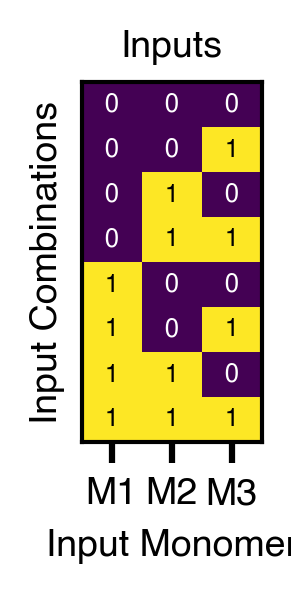

In [37]:
save = True

overall_width = (cell_width*num_inputs)+label_pad
overall_height = (cell_height*len(input_combos))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':label_pad/overall_width,\
                        'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})

cmap = plt.get_cmap('viridis')

# Plot input combos
vmin=0
vmax=1
input_heatmap = ax.pcolormesh(np.arange(num_inputs),np.arange(len(input_combos))[::-1],np.array(input_combos),\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest',rasterized=False)
for (j,i),label in np.ndenumerate(np.array(input_combos)[::-1,:]):
    if label>(vmin+(0.5*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = ax.text(i,j,int(label),ha='center',va='center',fontsize=6,font='Helvetica',color=color)
_ = ax.set_xlabel(f'Input Monomer',fontsize=9,font='Helvetica')
_ = ax.set_ylabel(f'Input Combinations',fontsize=9,font='Helvetica')
_ = ax.set_title('Inputs',fontsize=9,font='Helvetica')

_ = ax.set_yticks([])
_ = ax.set_xticks(list(range(num_inputs)))
_ = ax.set_xticklabels([f'M{x+1}' for x in range(num_inputs)])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

fig.set_dpi(300)

if save:
    filename = f'FigS4A_{num_inputs}input_logic_inputs'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot all responses

In [76]:
save = True
plot_objective_only = False
out_range = [1e-3,1e-1]

In [77]:
cell_height = 0.15
cell_width = 0.15
label_pad = 0.4

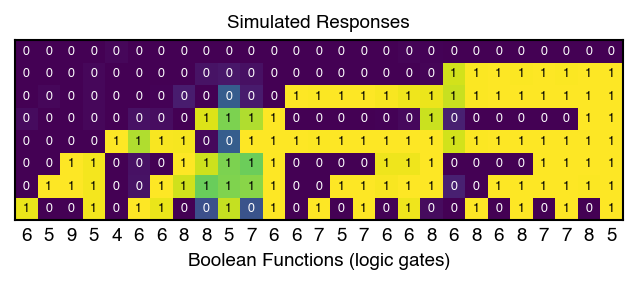

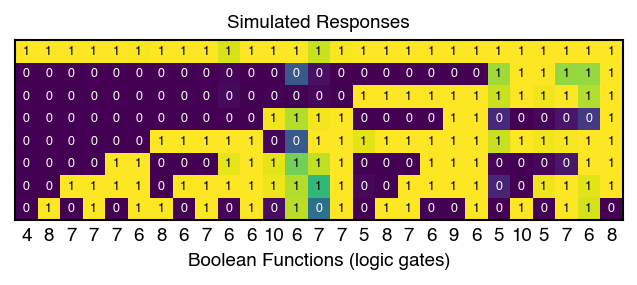

In [40]:
cmap = plt.get_cmap('viridis')
objective_function_ids_by_figure = [
    list(range(int(math.ceil(len(objective_functions)/2)))),
    list(range(int(math.ceil(len(objective_functions)/2)),len(objective_functions)))
]
for figure_i in range(2):
    overall_width = (cell_width*len(objective_function_ids_by_figure[figure_i]))
    overall_height = (cell_height*len(input_combos))+(2*label_pad)
    fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                            'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})
    
    output_matrix = np.zeros((len(input_combos),len(objective_function_ids_by_figure[figure_i])))
    xtick_labels = []
    successful_objectives = 0
    for x_position, objective_i in enumerate(objective_function_ids_by_figure[figure_i]):
        if plot_objective_only:
            output_matrix[:,objective_i] = objective_gates[objective_i]
        else:
            m_temp = [m_temp for m_temp in m_list if objective_i in successful_3D_gates_by_m[m_temp]][0]
            param_set = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
            best_dimer = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
            
            C0,S_all  = simulate_networks(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
            S_all[np.where(S_all<10**input_lb)] = 10**input_lb
            outputs = np.full((len(input_combos),),off_value)
            off_val = np.min(objective_functions[objective_i])
            on_val = np.max(objective_functions[objective_i])
            max_off_val = off_val
            min_on_val = on_val
            for input_combo_i,input_combo in enumerate(input_combos):
                # construct input indices
                slice_ids = []
                for input_ in input_combo:
                    if input_==0:
                        slice_ids.append(list(range(transition_point_id)))
                    elif input_==1:
                        slice_ids.append(list(range(transition_point_id,t)))
                simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
                outputs[input_combo_i] = 10**np.mean(np.log10(simulated_vals))
                if (objective_gates[objective_i][input_combo_i]==0):
                    # outputs[input_combo_i] = np.max(np.log10(simulated_vals))
                    if (np.max(simulated_vals)>max_off_val):
                        max_off_val = np.max(simulated_vals)
                if (objective_gates[objective_i][input_combo_i]==1):
                    # outputs[input_combo_i] = np.min(np.log10(simulated_vals))
                    if (np.min(simulated_vals)<min_on_val):
                        min_on_val = np.min(simulated_vals)
            output_matrix[:,x_position] = outputs
            if min_on_val>max_off_val:
                successful_objectives += 1
                xtick_labels.append(str(m_temp))
                # Print a number
                # ax.text(x_position-0.1,-0.95,str(m_temp),color='k',font='Helvetica',fontsize=9,transform=ax.transData)
                # ax.text(x_position-0.15,-1.1,u'\u2713',color='k',font='DejaVu Sans',fontsize=20,transform=ax.transData)
            else:
                # Print a red X
                # ax.text(x_position-0.2,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=20,transform=ax.transData)
                xtick_labels.append('X')
            

    if plot_objective_only:
        vmin = 0
        vmax = 1
        output_heatmap = ax.pcolormesh(np.arange(len(objective_function_ids_by_figure[figure_i])),np.arange(len(input_combos))[::-1],output_matrix,\
                                            cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                                shading = 'nearest',rasterized=False)
        ax.set_title('Target Responses')
    else:
        vmin=out_range[0]
        vmax=out_range[1]
        output_heatmap = ax.pcolormesh(np.arange(len(objective_function_ids_by_figure[figure_i])),np.arange(len(input_combos))[::-1],output_matrix,\
                                            cmap = cmap,norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax),\
                                                shading = 'nearest',rasterized=False)
        # fig.colorbar(output_heatmap,ax=ax,label='Log (Concentration) (unitless)')
        ax.set_title('Simulated Responses')

    for (j,i),label in np.ndenumerate(np.array(objective_gates[objective_function_ids_by_figure[figure_i]]).T[::-1,:]):
        if output_matrix[::-1,:][j,i]>10**((np.log10(vmin)+(0.5*(np.log10(vmax)-np.log10(vmin))))):
            color='black'
        else:
            color='white'
        _ = ax.text(i,j,int(label),ha='center',va='center',fontsize=6,color=color)

    _ = ax.set_xlabel(f'Boolean Functions (logic gates)')
    _ = ax.set_xticks(list(range(len(objective_function_ids_by_figure[figure_i]))),\
                        labels = xtick_labels,color='k',fontsize=9,font='Helvetica')
    _ = ax.set_yticks([])
    _ = ax.tick_params(axis='x',length=0)

    # Customize spines
    set_spine_linewidth(ax,1)

    if save:
        filename = f'FigS4A_{num_inputs}input_logic_responses_{figure_i}'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                    transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

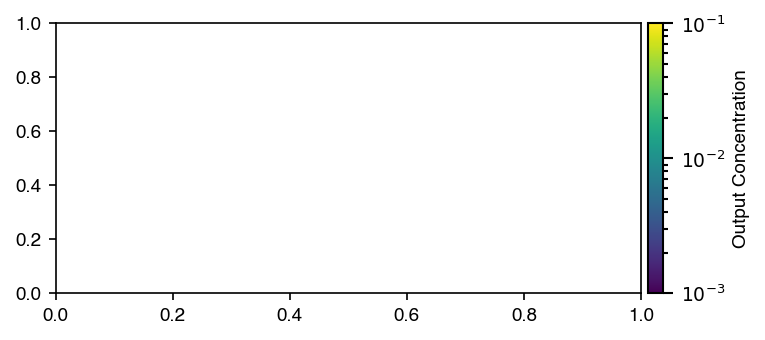

In [45]:
save = True

cmap = plt.get_cmap('viridis')
objective_function_ids_by_figure = [
    list(range(int(math.ceil(len(objective_functions)/2)))),
    list(range(int(math.ceil(len(objective_functions)/2)),len(objective_functions)))
]
figure_i = 0
overall_width = (cell_width*len(objective_function_ids_by_figure[figure_i]))
overall_height = (1.5*(cell_height*len(input_combos)))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                            'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})

# "Color" bar
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="2.5%", pad=0.05)
colorbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]), cmap=plt.get_cmap('viridis')),\
                        cax=cax1,label='Output Concentration')
colorbar.outline.set_linewidth(1)

# Set ticks
set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),\
                     max_labels=4)

# Customize the major ticks
cax1.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
cax1.tick_params(axis='both', which='minor', length=2.5, width=1)   # Length and linewidth of minor ticks

if save:
    filename = f'FigS4A_{num_inputs}input_logic_responses_colorbar'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

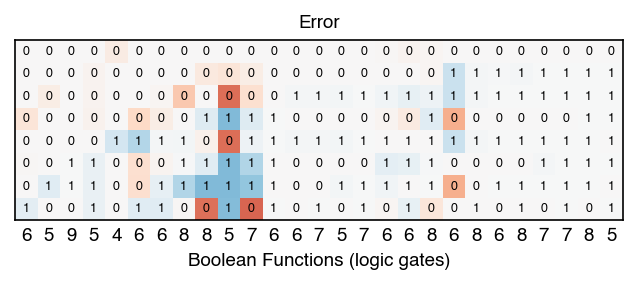

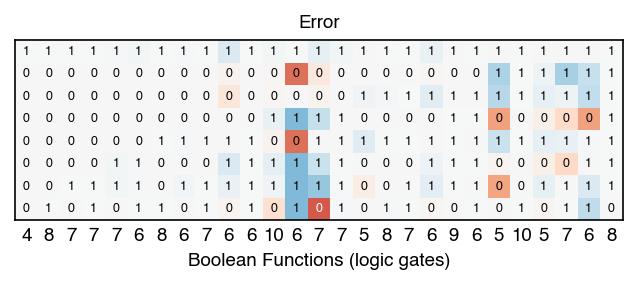

In [42]:
objective_function_ids_by_figure = [
    list(range(int(math.ceil(len(objective_functions)/2)))),
    list(range(int(math.ceil(len(objective_functions)/2)),len(objective_functions)))
]
for figure_i in range(2):
    overall_width = (cell_width*len(objective_function_ids_by_figure[figure_i]))
    overall_height = (cell_height*len(input_combos))+(2*label_pad)
    fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                            'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})
    
    cost_matrix = np.zeros((len(input_combos),len(objective_function_ids_by_figure[figure_i])))
    xtick_labels = []
    successful_objectives = 0
    for x_position, objective_i in enumerate(objective_function_ids_by_figure[figure_i]):
        m_temp = [m_temp for m_temp in m_list if objective_i in successful_3D_gates_by_m[m_temp]][0]
        param_set = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
        best_dimer = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
        off_val = np.min(objective_functions[objective_i])
        on_val = np.max(objective_functions[objective_i])

        C0,S_all  = simulate_networks(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
        S_all[np.where(S_all<10**input_lb)] = 10**input_lb
        costs = np.zeros((len(input_combos),))
        max_off_val = off_val
        min_on_val = on_val
        for input_combo_i,input_combo in enumerate(input_combos):
            # construct input indices
            slice_ids = []
            for input_ in input_combo:
                if input_==0:
                    slice_ids.append(list(range(transition_point_id)))
                elif input_==1:
                    slice_ids.append(list(range(transition_point_id,t)))
            # objective_vals = objective_function.reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
            simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
            if objective_gates[objective_i][input_combo_i]==0:
                if np.max(simulated_vals) <= off_val:
                    costs[input_combo_i] = 0
                else:
                    costs[input_combo_i] = np.max(np.log10(simulated_vals)-np.log10(off_val))
                if np.max(simulated_vals)>max_off_val:
                    max_off_val = np.max(simulated_vals)
            elif objective_gates[objective_i][input_combo_i]==1:
                if np.min(simulated_vals) >= on_val:
                    costs[input_combo_i] = 0
                else:
                    costs[input_combo_i] = np.min(np.log10(simulated_vals) - np.log10(on_val))
                if np.min(simulated_vals)<min_on_val:
                    min_on_val = np.min(simulated_vals)
            cost_matrix[:,x_position] = costs
        if min_on_val>max_off_val:
            successful_objectives += 1
            xtick_labels.append(str(m_temp))
            # Print a number
            # ax.text(x_position-0.1,-0.95,str(m_temp),color='k',font='Helvetica',fontsize=9,transform=ax.transData)
            # ax.text(x_position-0.15,-1.1,u'\u2713',color='k',font='DejaVu Sans',fontsize=20,transform=ax.transData)
        else:
            # Print a red X
            # ax.text(x_position-0.2,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=20,transform=ax.transData)
            xtick_labels.append('X')
            
    vmin=out_range[0]
    vmax=out_range[1]
    output_heatmap = ax.pcolormesh(np.arange(len(objective_function_ids_by_figure[figure_i])),np.arange(len(input_combos))[::-1],cost_matrix,\
                                        cmap = cmap,norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax),\
                                            shading = 'nearest',rasterized=False)
    # fig.colorbar(output_heatmap,ax=ax,label='Log (Concentration) (unitless)')
    ax.set_title('Error')

    cmap = plt.get_cmap('RdBu')
    cmap = cmap.copy().reversed()
    vmin = -2
    vmax = 2
    output_heatmap = ax.pcolormesh(np.arange(len(objective_function_ids_by_figure[figure_i])),np.arange(len(input_combos))[::-1],cost_matrix,\
                                        cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                            shading = 'nearest',rasterized=False)

    for (j,i),label in np.ndenumerate(np.array(objective_gates[objective_function_ids_by_figure[figure_i]]).T[::-1,:]):
        if cost_matrix[::-1,:][j,i]>(vmin+(0.2*(vmax-vmin))) and cost_matrix[::-1,:][j,i]<(vmin+(0.8*(vmax-vmin))):
            color='black'
        else:
            color='white'
        _ = ax.text(i,j,int(label),ha='center',va='center',fontsize=6,color=color)

    _ = ax.set_xlabel(f'Boolean Functions (logic gates)')
    _ = ax.set_xticks(list(range(len(objective_function_ids_by_figure[figure_i]))),\
                        labels = xtick_labels,color='k',fontsize=9,font='Helvetica')
    _ = ax.set_yticks([])
    _ = ax.tick_params(axis='x',length=0)

    if save:
        filename = f'Fig5Supp_{num_inputs}input_logic_error_{figure_i}'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                    transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

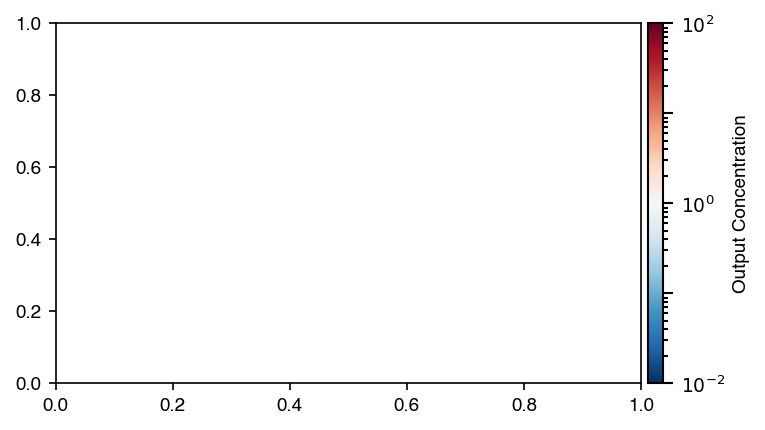

In [80]:
save = True

objective_function_ids_by_figure = [
    list(range(int(math.ceil(len(objective_functions)/2)))),
    list(range(int(math.ceil(len(objective_functions)/2)),len(objective_functions)))
]
figure_i = 0
overall_width = (cell_width*len(objective_function_ids_by_figure[figure_i]))
overall_height = (2*(cell_height*len(input_combos)))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                            'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})



# "Color" bar
cmap = plt.get_cmap('RdBu')
cmap = cmap.copy().reversed()
vmin = -2
vmax = 2

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="2.5%", pad=0.05)
colorbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=10**vmin,vmax=10**vmax), cmap=cmap),\
                        cax=cax1,label='Output Concentration')
colorbar.outline.set_linewidth(1)

# Set ticks
set_simple_log_ticks(cax1,which='y',log_lowerbound=vmin,log_upperbound=vmax,max_labels=4)

# Customize the major ticks
cax1.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
cax1.tick_params(axis='both', which='minor', length=2.5, width=1)   # Length and linewidth of minor ticks

if save:
    filename = f'Fig5Supp_{num_inputs}input_logic_error_colorbar'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot schematic

In [52]:
objective_i = 38
print(objective_gates[objective_i])

[1 0 0 1 0 1 1 0]


In [53]:
m = [m_temp for m_temp in m_list if objective_i in successful_3D_gates_by_m[m_temp]][0]
param_set = np.load(str(pathlib.Path(specific_load_dir,f'{m}M_{num_inputs}input_logic',f'{m}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
param_sets = np.expand_dims(param_set,axis=0)
best_dimer = int(np.load(str(pathlib.Path(specific_load_dir,f'{m}M_{num_inputs}input_logic',f'{m}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True))

In [54]:
# Rearrange monomers for easier labeling
param_sets = swap_monomer_labels(m,num_inputs,param_sets,{1:3,3:1})
best_dimer = swap_monomer_labels_output_dimer(m,dimer_id=best_dimer,map={1:3,3:1})

In [55]:
save = True

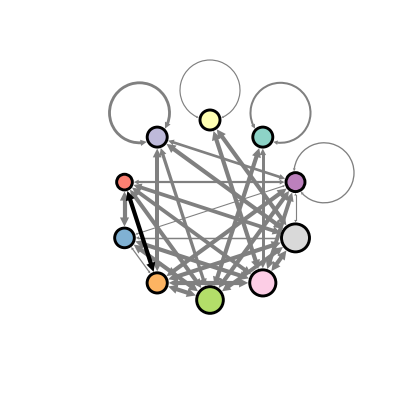

In [56]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[best_dimer]]), # Index of output dimer
                                        input_node_values=np.array([0 for input in range(num_inputs)]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.1, # Radius of loops around nodes 
                                        node_scales = [-1,1,3,8], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-3,3,0.25,1], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set3', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.7,
)

fig.set_dpi(300)

if save:
    filename = f'Fig5A_{m}M_objective{objective_i}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

## Figure 5B

https://www.boolean-algebra.com/?q=KHtBfXtCfXtDfSkrKHtBfUJDKSsoQXtCfUMpKyhBQntDfSk=

## Figure 5C

Expressivity of three-input logic gates, by network size

In [20]:
input_lb = -3 # Load10 of lower bound of input range
input_ub = 3 # Load10 of upper bound of input range
t = 4 # Number of points along each input axis to simulate

round_low_concs_to = 10**-3
num_inputs =3

In [21]:
successful_3D_gates_by_m = np.load(str(pathlib.Path(specific_load_dir,f'{num_inputs}input_successful_gates_by_m.npy')),allow_pickle=True).tolist()

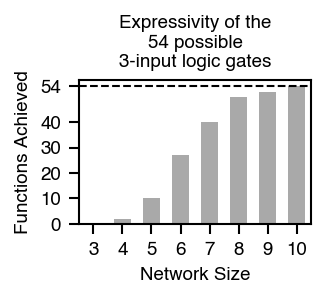

In [25]:
save = True

fig, ax = plt.subplots(figsize=(2,1.25))

ax.bar(list(successful_3D_gates_by_m.keys()),\
       np.cumsum([len(x) for x in successful_3D_gates_by_m.values()]),\
       width=0.6,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Functions Achieved')
num_objectives = len(objective_functions)
_ = ax.set_title(f'Expressivity of all\n{num_inputs}-input logic gates')
_ = ax.set_xticks(list(range(min(list(successful_3D_gates_by_m.keys())),max(list(successful_3D_gates_by_m.keys()))+1)))

if num_objectives==54:
       _ = ax.set_yticks([0,10,20,30,40,54])


xmin = min(list(successful_3D_gates_by_m.keys()))-0.5
xmax = max(list(successful_3D_gates_by_m.keys()))+0.5

_ = ax.hlines(y=len(objective_functions),xmin=xmin,\
              xmax=xmax,linestyle='--',colors='k',linewidth=1)

_ = ax.set_xlim([xmin,xmax])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

if save:
    filename = f'Fig5C_num_3D_gates_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure 5D, Figure S4B

Four-input logic gates (for AT LEAST 1, AT LEAST 2, AT LEAST 3, AND) performed by networks of various sizes.

In [23]:
input_lb = -3 # Load10 of lower bound of input range
input_ub = 3 # Load10 of upper bound of input range
t = 4 # Number of points along each input axis to simulate

round_low_concs_to = 10**-3
num_inputs =4

In [24]:
successful_4D_gates_by_m = np.load(str(pathlib.Path(specific_load_dir,f'{num_inputs}input_successful_gates_by_m.npy')),allow_pickle=True).tolist()

In [25]:
m_list = list(successful_4D_gates_by_m.keys())

### Create Objectives

In [26]:
objective_functions = []

In [27]:
desired_transition_val = 1e0
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
closest_x_point_id = np.argmin(np.abs(np.log10(x_points)-np.log10(desired_transition_val)))
# manually define transition:
transition_point_id = 2

In [28]:
off_value = 1e-3
on_value = 1e-1

For the purposes of higher dimensions, we will choose just a few types of gates to investigate

In [29]:
input_combos = list(itertools.product(range(2),repeat=num_inputs))
num_input_combos = len(input_combos)
objective_gates = []

# AT LEAST and AND
for at_least in range(1,num_inputs+1):
    objective_gates.append([1 if np.where(input_combo)[0].shape[0]>=at_least else 0 for input_combo in input_combos])

objective_gates = np.array(objective_gates)

In [30]:
for gate in objective_gates:
    # Initialize objective with all "off" values
    objective = np.full(tuple([t for i in range(num_inputs)]),off_value,dtype=np.float64)
    for input_combo_i,input_combo in enumerate(input_combos):
        # For each input combination that's supposed to give an "on" value, index those inputs and set the output to on
        if gate[input_combo_i]==0:
            continue
        # construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        # Set those indices to on
        objective[tuple(np.array(list(itertools.product(*slice_ids))).T)] = on_value
    objective = objective.flatten()
    objective_functions.append(objective)

### Plot input combos

In [57]:
cell_height = 0.15
cell_width = 0.2
label_pad = 0.4

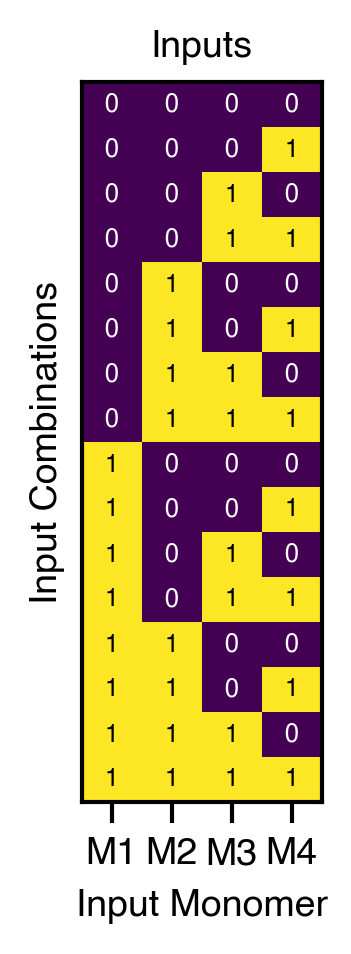

In [58]:
save = True

overall_width = (cell_width*num_inputs)+label_pad
overall_height = (cell_height*len(input_combos))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':label_pad/overall_width,\
                        'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})

cmap = plt.get_cmap('viridis')

# Plot input combos
vmin=0
vmax=1
input_heatmap = ax.pcolormesh(np.arange(num_inputs),np.arange(len(input_combos))[::-1],np.array(input_combos),\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest',rasterized=False)
for (j,i),label in np.ndenumerate(np.array(input_combos)[::-1,:]):
    if label>(vmin+(0.5*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = ax.text(i,j,int(label),ha='center',va='center',fontsize=6,font='Helvetica',color=color)
_ = ax.set_xlabel(f'Input Monomer',fontsize=9,font='Helvetica')
_ = ax.set_ylabel(f'Input Combinations',fontsize=9,font='Helvetica')
_ = ax.set_title('Inputs',fontsize=9,font='Helvetica')

_ = ax.set_yticks([])
_ = ax.set_xticks(list(range(num_inputs)))
_ = ax.set_xticklabels([f'M{x+1}' for x in range(num_inputs)])

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

fig.set_dpi(300)

if save:
    filename = f'FigS4B_{num_inputs}input_logic_inputs'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot all responses

In [61]:
save = True
plot_objective_only = False
out_range = [1e-3,1e-1]

In [63]:
cell_height = 0.15
cell_width = 0.15
label_pad = 0.4

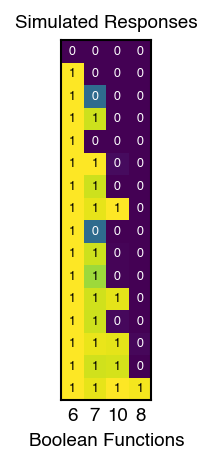

In [64]:
cmap = plt.get_cmap('viridis')

overall_width = (cell_width*len(objective_functions))
overall_height = (cell_height*len(input_combos))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                        'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})

output_matrix = np.zeros((len(input_combos),len(objective_functions)))
xtick_labels = []
successful_objectives = 0
for objective_i in range(len(objective_functions)):
    if plot_objective_only:
        output_matrix[:,objective_i] = objective_gates[objective_i]
    else:
        m_temp = [m_temp for m_temp in m_list if objective_i in successful_4D_gates_by_m[m_temp]][0]
        param_set = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
        best_dimer = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
        
        C0,S_all  = simulate_networks(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
        S_all[np.where(S_all<10**input_lb)] = 10**input_lb
        outputs = np.full((len(input_combos),),off_value)
        off_val = np.min(objective_functions[objective_i])
        on_val = np.max(objective_functions[objective_i])
        max_off_val = off_val
        min_on_val = on_val
        for input_combo_i,input_combo in enumerate(input_combos):
            # construct input indices
            slice_ids = []
            for input_ in input_combo:
                if input_==0:
                    slice_ids.append(list(range(transition_point_id)))
                elif input_==1:
                    slice_ids.append(list(range(transition_point_id,t)))
            simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
            outputs[input_combo_i] = 10**np.mean(np.log10(simulated_vals))
            if (objective_gates[objective_i][input_combo_i]==0):
                # outputs[input_combo_i] = np.max(np.log10(simulated_vals))
                if (np.max(simulated_vals)>max_off_val):
                    max_off_val = np.max(simulated_vals)
            if (objective_gates[objective_i][input_combo_i]==1):
                # outputs[input_combo_i] = np.min(np.log10(simulated_vals))
                if (np.min(simulated_vals)<min_on_val):
                    min_on_val = np.min(simulated_vals)
        output_matrix[:,objective_i] = outputs
        if min_on_val>max_off_val:
            successful_objectives += 1
            xtick_labels.append(str(m_temp))
            # Print a number
            # ax.text(objective_i-0.1,-0.95,str(m_temp),color='k',font='Helvetica',fontsize=9,transform=ax.transData)
            # ax.text(objective_i-0.15,-1.1,u'\u2713',color='k',font='DejaVu Sans',fontsize=20,transform=ax.transData)
        else:
            # Print a red X
            # ax.text(objective_i-0.2,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=20,transform=ax.transData)
            xtick_labels.append('X')
        

if plot_objective_only:
    vmin = 0
    vmax = 1
    output_heatmap = ax.pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],output_matrix,\
                                        cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                            shading = 'nearest',rasterized=False)
    ax.set_title('Target Responses')
else:
    vmin=out_range[0]
    vmax=out_range[1]
    output_heatmap = ax.pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],output_matrix,\
                                        cmap = cmap,norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax),\
                                            shading = 'nearest',rasterized=False)
    # fig.colorbar(output_heatmap,ax=ax,label='Log (Concentration) (unitless)')
    ax.set_title('Simulated Responses')

for (j,i),label in np.ndenumerate(np.array(objective_gates).T[::-1,:]):
    if output_matrix[::-1,:][j,i]>10**((np.log10(vmin)+(0.5*(np.log10(vmax)-np.log10(vmin))))):
        color='black'
    else:
        color='white'
    _ = ax.text(i,j,int(label),ha='center',va='center',fontsize=6,color=color)

_ = ax.set_xlabel(f'Boolean Functions')
_ = ax.set_xticks(list(range(len(objective_functions))),\
                    labels = xtick_labels,color='k',fontsize=9,font='Helvetica')
_ = ax.set_yticks([])
_ = ax.tick_params(axis='x',length=0)

# Customize spines
set_spine_linewidth(ax,1)

if save:
    filename = f'FigS4B_{num_inputs}input_logic_responses'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

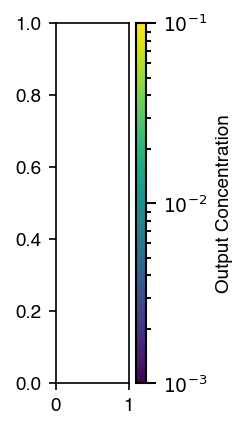

In [65]:
save = True

cmap = plt.get_cmap('viridis')
objective_function_ids_by_figure = [
    list(range(int(math.ceil(len(objective_functions)/2)))),
    list(range(int(math.ceil(len(objective_functions)/2)),len(objective_functions)))
]
figure_i = 0
overall_width = (cell_width*len(objective_function_ids_by_figure[figure_i]))
overall_height = (1.5*(cell_height*len(input_combos)))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                            'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})

# "Color" bar
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="2.5%", pad=0.05)
colorbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]), cmap=plt.get_cmap('viridis')),\
                        cax=cax1,label='Output Concentration')
colorbar.outline.set_linewidth(1)

# Set ticks
set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),\
                     max_labels=4)

# Customize the major ticks
cax1.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
cax1.tick_params(axis='both', which='minor', length=2.5, width=1)   # Length and linewidth of minor ticks

if save:
    filename = f'FigS4A_{num_inputs}input_logic_responses_colorbar'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

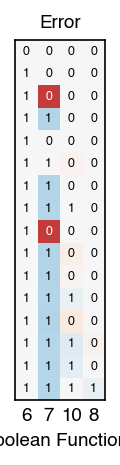

In [66]:
overall_width = (cell_width*len(objective_functions))
overall_height = (cell_height*len(input_combos))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                        'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})

cost_matrix = np.zeros((len(input_combos),len(objective_functions)))
xtick_labels = []
successful_objectives = 0
for objective_i in range(len(objective_functions)):
    m_temp = [m_temp for m_temp in m_list if objective_i in successful_4D_gates_by_m[m_temp]][0]
    param_set = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
    best_dimer = np.load(str(pathlib.Path(specific_load_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
    off_val = np.min(objective_functions[objective_i])
    on_val = np.max(objective_functions[objective_i])

    C0,S_all  = simulate_networks(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    costs = np.zeros((len(input_combos),))
    max_off_val = off_val
    min_on_val = on_val
    for input_combo_i,input_combo in enumerate(input_combos):
        # construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        # objective_vals = objective_function.reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
        simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
        if objective_gates[objective_i][input_combo_i]==0:
            if np.max(simulated_vals) <= off_val:
                costs[input_combo_i] = 0
            else:
                costs[input_combo_i] = np.max(np.log10(simulated_vals)-np.log10(off_val))
            if np.max(simulated_vals)>max_off_val:
                max_off_val = np.max(simulated_vals)
        elif objective_gates[objective_i][input_combo_i]==1:
            if np.min(simulated_vals) >= on_val:
                costs[input_combo_i] = 0
            else:
                costs[input_combo_i] = np.min(np.log10(simulated_vals) - np.log10(on_val))
            if np.min(simulated_vals)<min_on_val:
                min_on_val = np.min(simulated_vals)
        cost_matrix[:,objective_i] = costs
    if min_on_val>max_off_val:
        successful_objectives += 1
        xtick_labels.append(str(m_temp))
        # Print a number
        # ax.text(objective_i-0.1,-0.95,str(m_temp),color='k',font='Helvetica',fontsize=9,transform=ax.transData)
        # ax.text(objective_i-0.15,-1.1,u'\u2713',color='k',font='DejaVu Sans',fontsize=20,transform=ax.transData)
    else:
        # Print a red X
        # ax.text(objective_i-0.2,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=20,transform=ax.transData)
        xtick_labels.append('X')
        
vmin=out_range[0]
vmax=out_range[1]
output_heatmap = ax.pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],cost_matrix,\
                                    cmap = cmap,norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax),\
                                        shading = 'nearest',rasterized=False)
# fig.colorbar(output_heatmap,ax=ax,label='Log (Concentration) (unitless)')
ax.set_title('Error')

cmap = plt.get_cmap('RdBu')
cmap = cmap.copy().reversed()
vmin = -2
vmax = 2
output_heatmap = ax.pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],cost_matrix,\
                                    cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                        shading = 'nearest',rasterized=False)

for (j,i),label in np.ndenumerate(np.array(objective_gates).T[::-1,:]):
    if cost_matrix[::-1,:][j,i]>(vmin+(0.2*(vmax-vmin))) and cost_matrix[::-1,:][j,i]<(vmin+(0.8*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = ax.text(i,j,int(label),ha='center',va='center',fontsize=6,color=color)

_ = ax.set_xlabel(f'Boolean Functions')
_ = ax.set_xticks(list(range(len(objective_functions))),\
                    labels = xtick_labels,color='k',fontsize=9,font='Helvetica')
_ = ax.set_yticks([])
_ = ax.tick_params(axis='x',length=0)

if save:
    filename = f'Fig5Supp_{num_inputs}input_logic_error'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

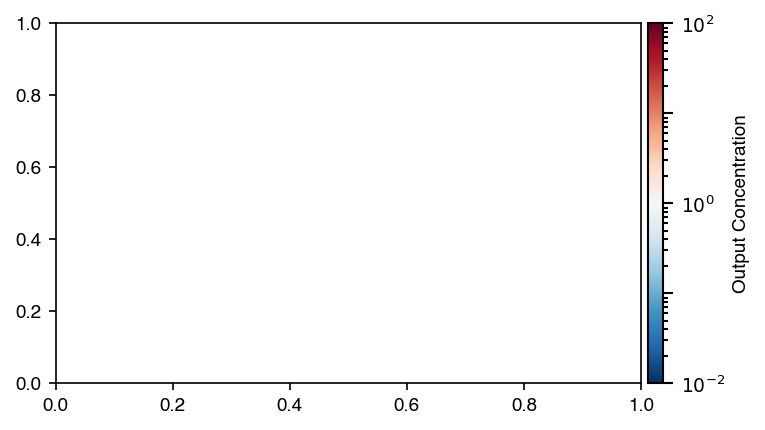

In [81]:
save = True

objective_function_ids_by_figure = [
    list(range(int(math.ceil(len(objective_functions)/2)))),
    list(range(int(math.ceil(len(objective_functions)/2)),len(objective_functions)))
]
figure_i = 0
overall_width = (cell_width*len(objective_function_ids_by_figure[figure_i]))
overall_height = (2*(cell_height*len(input_combos)))+(2*label_pad)
fig, ax = plt.subplots(figsize=(overall_width,overall_height),gridspec_kw={'left':0,\
                            'bottom':label_pad/overall_height,'right':1,'top':1-(label_pad/overall_height)})



# "Color" bar
cmap = plt.get_cmap('RdBu')
cmap = cmap.copy().reversed()
vmin = -2
vmax = 2

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="2.5%", pad=0.05)
colorbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=10**vmin,vmax=10**vmax), cmap=cmap),\
                        cax=cax1,label='Output Concentration')
colorbar.outline.set_linewidth(1)

# Set ticks
set_simple_log_ticks(cax1,which='y',log_lowerbound=vmin,log_upperbound=vmax,max_labels=4)

# Customize the major ticks
cax1.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
cax1.tick_params(axis='both', which='minor', length=2.5, width=1)   # Length and linewidth of minor ticks

if save:
    filename = f'Fig5Supp_{num_inputs}input_logic_error_colorbar'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot schematic

In [37]:
objective_i = 2
print(objective_gates[objective_i])

[0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1]


In [38]:
m = [m_temp for m_temp in m_list if objective_i in successful_4D_gates_by_m[m_temp]][0]
param_set = np.load(str(pathlib.Path(specific_load_dir,f'{m}M_{num_inputs}input_logic',f'{m}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
param_sets = np.expand_dims(param_set,axis=0)
best_dimer = int(np.load(str(pathlib.Path(specific_load_dir,f'{m}M_{num_inputs}input_logic',f'{m}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True))

In [39]:
# Rearrange monomers for easier labeling
param_sets = swap_monomer_labels(m,num_inputs,param_sets,{1:4,4:1,2:3,3:2})
best_dimer = swap_monomer_labels_output_dimer(m,dimer_id=best_dimer,map={1:4,4:1,2:3,3:2})
print("Output dimer: {}".format(make_nXn_species_names(m)[m+best_dimer]))

Output dimer: D_6_8


In [41]:
save = True

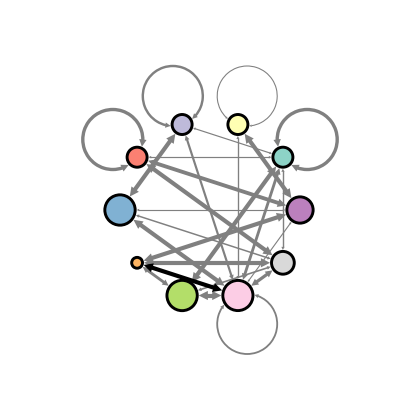

In [44]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[best_dimer]]), # Index of output dimer
                                        input_node_values=np.array([0 for input in range(num_inputs)]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.1, # Radius of loops around nodes 
                                        node_scales = [-1,1,3,8], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-3,3,0.25,1], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set3', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        labels=False,
                                        upscale_arrowhead=1.1,
                                        node_edge_width=0.7,
)

fig.set_dpi(300)

if save:
    filename = f'Fig5A_{m}M_objective{objective_i}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight',pad_inches=0)

## Figure 5E

https://www.boolean-algebra.com/?q=KHtBfUJDRCkrKEF7Qn1DRCkrKEFCe0N9RCkrKEFCQ3tEfSkrKEFCQ0Qp

## Figure 5G

In [11]:
required_m_by_gate_2input = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_2input.npy')))
num_ANDOR_gates_2input = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_2input.npy')))

required_m_by_gate_3input = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_3input.npy')))
num_ANDOR_gates_3input = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_3input.npy')))

required_m_by_gate_4input = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_4input.npy')))
num_ANDOR_gates_4input = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_4input.npy')))

required_m_by_gate_all = np.load(str(pathlib.Path(out_dir,'required_m_by_gate_all.npy')))
num_ANDOR_gates_all = np.load(str(pathlib.Path(out_dir,'num_ANDOR_gates_all.npy')))

In [12]:
triple_colors = [
        (171,108,0), # Brown
        (64,176,166), # Teal
        (122, 68, 194), # Purple
]

triple_colors = [tuple([x/255 for x in color]) for color in triple_colors]

cmap = mcolors.ListedColormap(triple_colors)

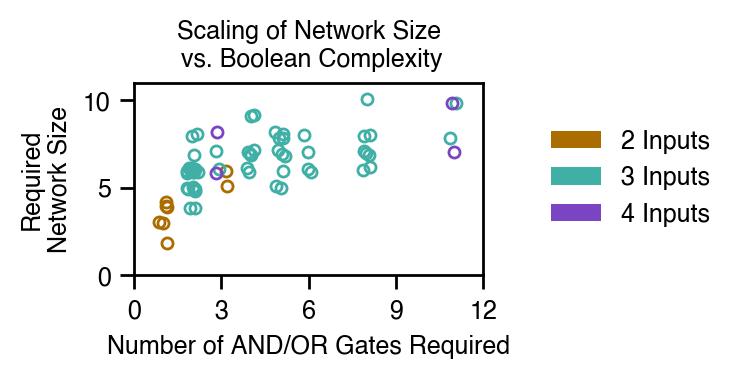

In [25]:
save = True

fig, ax = plt.subplots(figsize=(2.25,1.25))

# Add jitter
rng = np.random.default_rng(42)
halfrange = 0.2
num_ANDOR_gates_byinput = [
    num_ANDOR_gates_2input,
    num_ANDOR_gates_3input,
    num_ANDOR_gates_4input,
]
required_m_by_gate_byinput = [
    required_m_by_gate_2input,
    required_m_by_gate_3input,
    required_m_by_gate_4input,
]
for i, num_inputs in enumerate(range(2,5)):
    ax.plot(np.array(num_ANDOR_gates_byinput[i])+rng.uniform(-halfrange,halfrange,size=len(num_ANDOR_gates_byinput[i])),\
            np.array(required_m_by_gate_byinput[i])+rng.uniform(-halfrange,halfrange,size=len(num_ANDOR_gates_byinput[i])),\
            marker='.',markersize=8,markerfacecolor='none',markeredgecolor=cmap(i),linestyle='',alpha=1,markeredgewidth=1)

ax.set_xlim([0,np.max(num_ANDOR_gates_all)+1])
ax.set_xticks(np.linspace(0,np.max(num_ANDOR_gates_all)+1,5))
ax.set_ylim([0,11])

_ = ax.set_xlabel('Number of AND/OR Gates Required')
_ = ax.set_ylabel('Required\nNetwork Size')
_ = ax.set_title('Scaling of Network Size\n vs. Boolean Complexity')

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

fig.set_dpi(200)

patches={}
for i, num_inputs in enumerate(range(2,5)):
    patches[i] = mpatches.Patch(facecolor=cmap(i),linewidth=0,linestyle='',\
                                                alpha=1,label=f'{num_inputs} Inputs',\
                                                edgecolor=None)

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'monomers_required_vs_boolean_complexity_byinputs'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')